# 시스템 손절매의 실례: 수익곡선 모멘텀 그림 2-38
- 투자 기간 :1986년 7월~2017년 6월
- 투자자산 : 코스피지수 월봉
- 투자 전략 : 12개월 평균 모멘텀 스코어 전략(연 3% 수익 가정 현금 혼합 전략) + 6개월 평균 모멘텀 스코어 시스템 손절매 전략
    - 12개월 평균 모멘텀 스코어 전략(현금 혼합)으로 전략이 마무리 되는 것이 아니라, 이 수익곡선 자체의 모멘텀 스코어를 매달 평가하여 기본 전략의 투자 비중을 매달 조절하는 전략입니다. 
    - 예를 들어 이번 달의 수익곡선 모멘텀 스코어가 0.75이었다면, 투자 비중은 평균 모멘텀 스코어 전략 75%, 현금 25%가 됩니다. 이중 75%만 전략에 투자합니다.
- 결과
    - 코스피 : 7.2%/-73.1%
    - 평균 모멘텀 스코어 현금 혼합 전략 : 6.4%/-19.1%
    - 수익곡선 모멘텀 전략 : 6.4%/-10.2%
    - 일종의 **시장 적응 전략(Market Adaptive Strategy)**

In [1]:
from settings import *

In [2]:
kospi = fdr.DataReader("KS11")['Close']
kospi

Date
1981-05-01    123.600
1981-05-02    123.500
1981-05-04    120.600
1981-05-06    120.700
1981-05-07    119.300
               ...   
2022-02-09   2768.850
2022-02-10   2771.930
2022-02-11   2747.710
2022-02-14   2704.480
2022-02-15   2676.540
Name: Close, Length: 10889, dtype: float64

In [3]:
kospi['1987-3']

Date
1987-03-02   337.850
1987-03-03   339.520
1987-03-04   344.040
1987-03-05   346.310
1987-03-06   350.510
1987-03-07   348.500
1987-03-09   348.500
1987-03-11   351.810
1987-03-12   353.090
1987-03-13   355.310
1987-03-14   359.110
1987-03-16   364.100
1987-03-17   361.980
1987-03-18   361.200
1987-03-19   365.360
1987-03-20   368.170
1987-03-21   369.620
1987-03-23   377.390
1987-03-24   380.080
1987-03-25   384.570
1987-03-26   393.410
1987-03-27   394.380
1987-03-28   389.320
1987-03-30   397.060
1987-03-31   405.130
Name: Close, dtype: float64

In [4]:
s='1985-1-4'
e='2017-6-30'
start평균모멘텀스코어='1986-2-1'
start수익곡선모멘텀= '1986-9-1' #'1987-3-2'# 12개월 적용시

In [5]:
data_daily = pd.DataFrame()
data_daily['KOSPI'] = kospi.copy()
data_daily = data_daily[s:e]
# %%
dd = pd.DataFrame()
dd.index = pd.date_range(s, e, freq='D')
denominator = len(pd.date_range(s, e, freq='D'))/len(pd.date_range(s, e, freq='Y'))
dd['현금'] = pow(1.03, 1/denominator)
dd['현금'] = dd['현금'].shift(1, fill_value=1.0)
dd['현금'] = dd['현금'].cumprod()
#%%
data_daily = pd.merge(data_daily, dd, left_index=True, right_index=True, how='left')
data_daily

,KOSPI,현금
Date,,
1985-01-04,139.530,1.000
1985-01-05,141.790,1.000
1985-01-07,145.510,1.000
1985-01-08,145.390,1.000
1985-01-09,143.260,1.000
...,...,...
2017-06-26,2388.660,2.574
2017-06-27,2391.950,2.574
2017-06-28,2382.560,2.574


In [6]:
class WeighAverageMomentumScoreIncludeCash(bt.Algo):
    """ 자산에 현금을 포함한 평균모멘텀스코어 전략
    
    매월초에 리밸런싱하고 전달 종가 기준으로 lookback 만큼의 월의 평균모멘텀스코어를 계산하여
    비중을 계산한다.
    """
    def __init__(self, lookback=12):
        super(WeighAverageMomentumScoreIncludeCash, self).__init__()
        self.lookback = lookback

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        average_momentum_score = pd.Series(dtype='float64')
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()

        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        # prc = target.universe[selected].loc[start:t0]
        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False

        weights = pd.Series(self.average_momentum_score(prc), index=selected)
        weights = weights/weights.sum()

        target.temp['weights'] = weights

        return True

In [7]:
class WeighAverageMomentumScoreExcludeCash(bt.Algo):
    """ 자산에 현금을 포함한 평균모멘텀스코어 전략
    
    매월초에 리밸런싱하고 전달 종가 기준으로 lookback 만큼의 월의 평균모멘텀스코어를 계산하여
    비중을 계산한다.
    """
    def __init__(self, lookback=12, cash='현금'):
        super(WeighAverageMomentumScoreExcludeCash, self).__init__()
        self.lookback = lookback
        self.cash     = cash

    def average_momentum_score(self, prc):
        ''' x : Series (DataFrame의 컬럼)
            x[-1] : 기준일. x의 현재값
            (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
            => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
        '''
        if len(prc) != (self.lookback+1):
            raise ValueError(f"must be resample('M').last(), {prc}")
        average_momentum_score = pd.Series(dtype='float64')
        for c in prc.columns:
            average_momentum_score[c] = np.mean(np.where(prc[c][-1]>prc[c], 1, 0)[:-1])# 당일 날짜 비교는 제외해준다 [:-1]

        return average_momentum_score

    def __call__(self, target):
        selected = target.temp['selected'].copy()
        selected.remove(self.cash)

        prev_month = target.now - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        # prc = target.universe[selected].loc[start:t0]
        prc = target.universe.loc[start:t0, selected].resample('M').last()
        print(f"\nprc : {target.now} {t0} ~ {start}") #{prc}
        if len(prc) < (self.lookback+1):
            print(f"{target.now} not yet data\n")
            return False

        weights = pd.Series(self.average_momentum_score(prc), index=selected)
        weights[self.cash] = 1 - weights.sum()

        target.temp['weights'] = weights

        return True

In [8]:
모멘텀_현금혼합 = bt.Strategy('모멘텀_현금혼합',
        [
            bt.algos.RunMonthly(run_on_first_date=True,
                                run_on_end_of_period=False, #월초
                                run_on_last_date=False),
            bt.algos.SelectAll(),
            WeighAverageMomentumScoreIncludeCash(12),
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)

수익곡선모멘텀6_children = bt.Strategy('수익곡선모멘텀6_children',
    [
        bt.algos.RunMonthly(run_on_first_date=True,
                            run_on_end_of_period=False, # 월초
                            run_on_last_date=False),
        bt.algos.SelectAll(),
        WeighAverageMomentumScoreExcludeCash(6, '현금'), 
        PrintTempWeights(),
        bt.algos.Rebalance()
    ],
    children =[모멘텀_현금혼합, '현금']
)

bt_수익곡선모멘텀6_children = bt.Backtest(수익곡선모멘텀6_children, data_daily, initial_capital=100000000)
r_수익곡선모멘텀6_children = bt.run(bt_수익곡선모멘텀6_children)


prc : 1985-01-04 00:00:00 1984-12 ~ 1983-12
1985-01-04 00:00:00 not yet data


prc : 1985-01-04 00:00:00 1984-12 ~ 1984-06
1985-01-04 00:00:00 not yet data


prc : 1985-01-04 00:00:00 1984-12 ~ 1983-12
1985-01-04 00:00:00 not yet data


prc : 1985-02-01 00:00:00 1985-01 ~ 1984-01
1985-02-01 00:00:00 not yet data


prc : 1985-02-01 00:00:00 1985-01 ~ 1984-07
1985-02-01 00:00:00 not yet data


prc : 1985-02-01 00:00:00 1985-01 ~ 1984-01
1985-02-01 00:00:00 not yet data


prc : 1985-03-02 00:00:00 1985-02 ~ 1984-02
1985-03-02 00:00:00 not yet data


prc : 1985-03-02 00:00:00 1985-02 ~ 1984-08
1985-03-02 00:00:00 not yet data


prc : 1985-03-02 00:00:00 1985-02 ~ 1984-02
1985-03-02 00:00:00 not yet data


prc : 1985-04-01 00:00:00 1985-03 ~ 1984-03
1985-04-01 00:00:00 not yet data


prc : 1985-04-01 00:00:00 1985-03 ~ 1984-09
1985-04-01 00:00:00 not yet data


prc : 1985-04-01 00:00:00 1985-03 ~ 1984-03
1985-04-01 00:00:00 not yet data


prc : 1985-05-01 00:00:00 1985-04 ~ 1984-04
1985-05

In [9]:
# start수익곡선모멘텀 = '1987-3-2'#start수익곡선모멘텀

In [10]:
r_수익곡선모멘텀6_children.set_date_range(start수익곡선모멘텀,e) #
r_수익곡선모멘텀6_children.display()

Stat                 수익곡선모멘텀6_children
-------------------  --------------------------
Start                1986-09-01
End                  2017-06-30
Risk-free rate       0.00%

Total Return         544.56%
Daily Sharpe         0.88
Daily Sortino        1.39
CAGR                 6.23%
Max Drawdown         -12.64%
Calmar Ratio         0.49

MTD                  1.06%
3m                   5.55%
6m                   9.20%
YTD                  9.20%
1Y                   10.23%
3Y (ann.)            4.34%
5Y (ann.)            2.53%
10Y (ann.)           2.61%
Since Incep. (ann.)  6.23%

Daily Sharpe         0.88
Daily Sortino        1.39
Daily Mean (ann.)    5.97%
Daily Vol (ann.)     6.80%
Daily Skew           0.08
Daily Kurt           10.86
Best Day             3.84%
Worst Day            -3.77%

Monthly Sharpe       0.85
Monthly Sortino      2.00
Monthly Mean (ann.)  6.39%
Monthly Vol (ann.)   7.54%
Monthly Skew         1.43
Monthly Kurt         5.00
Best Month           10.80%
Worst Month

                   CAGR
수익곡선모멘텀6_children 6.231
                      MDD
수익곡선모멘텀6_children -12.642


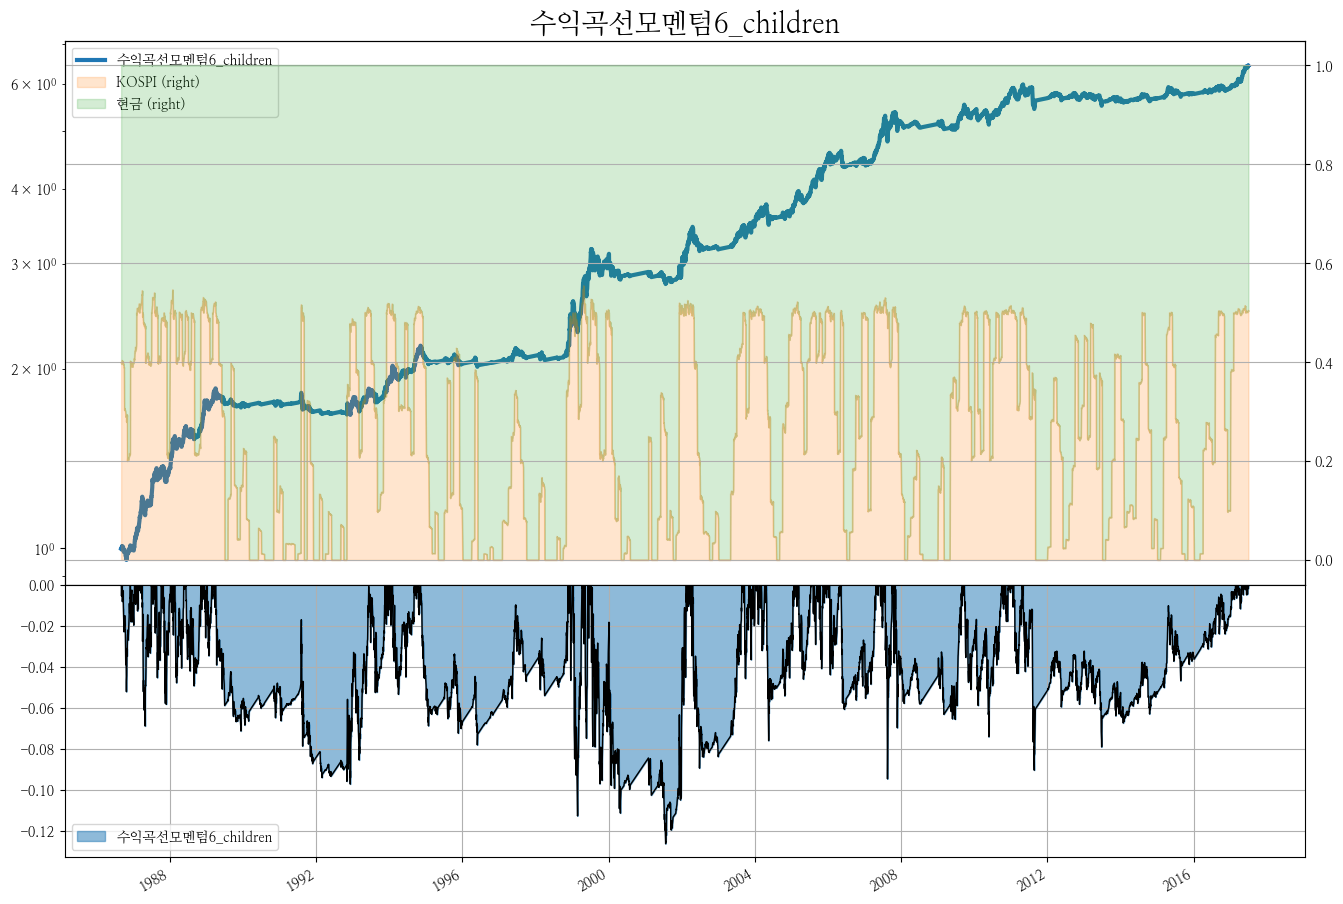

In [11]:
plot_assets(r_수익곡선모멘텀6_children, start수익곡선모멘텀,e, "수익곡선모멘텀6_children")

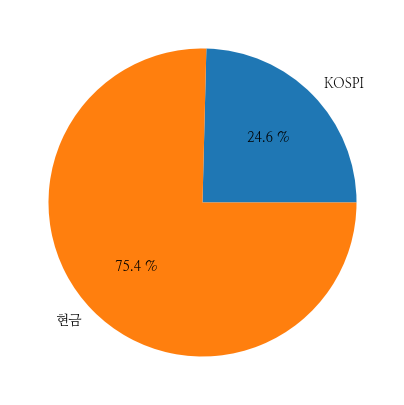

In [12]:
r_수익곡선모멘텀6_children.get_security_weights()[start수익곡선모멘텀:e].sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(5,5));

<AxesSubplot:>

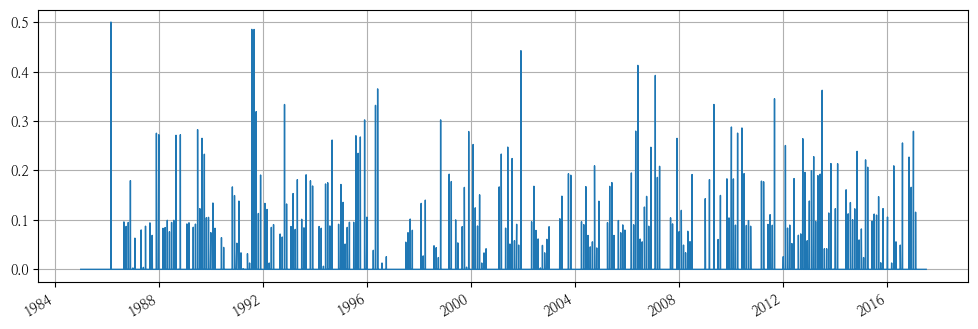

In [13]:
bt_수익곡선모멘텀6_children.turnover.plot(figsize=(12,4))

In [14]:
r_수익곡선모멘텀6_children.get_transactions()

price      quantity
Date       Security                       
1985-08-01 현금          1.017  98347786.000
1986-03-03 KOSPI     179.330    283612.000
           현금          1.034 -98347786.000
1986-04-01 KOSPI     200.150    -14457.000
1986-05-01 KOSPI     202.880     -1493.000
...                      ...           ...
2017-02-01 현금          2.544 -48273132.000
2017-03-02 KOSPI    2102.650      -738.000
2017-04-03 KOSPI    2167.510     -2443.000
2017-05-02 KOSPI    2219.670     -1864.000
2017-06-01 KOSPI    2344.610     -4431.000

[632 rows x 2 columns]

In [15]:
bt_모멘텀_현금혼합 = bt.Backtest(모멘텀_현금혼합, data_daily, initial_capital=100000000)
r_모멘텀_현금혼합 = bt.run(bt_모멘텀_현금혼합)


prc : 1985-01-04 00:00:00 1984-12 ~ 1983-12
1985-01-04 00:00:00 not yet data


prc : 1985-02-01 00:00:00 1985-01 ~ 1984-01
1985-02-01 00:00:00 not yet data


prc : 1985-03-02 00:00:00 1985-02 ~ 1984-02
1985-03-02 00:00:00 not yet data


prc : 1985-04-01 00:00:00 1985-03 ~ 1984-03
1985-04-01 00:00:00 not yet data


prc : 1985-05-01 00:00:00 1985-04 ~ 1984-04
1985-05-01 00:00:00 not yet data


prc : 1985-06-01 00:00:00 1985-05 ~ 1984-05
1985-06-01 00:00:00 not yet data


prc : 1985-07-01 00:00:00 1985-06 ~ 1984-06
1985-07-01 00:00:00 not yet data


prc : 1985-08-01 00:00:00 1985-07 ~ 1984-07
1985-08-01 00:00:00 not yet data


prc : 1985-09-02 00:00:00 1985-08 ~ 1984-08
1985-09-02 00:00:00 not yet data


prc : 1985-10-02 00:00:00 1985-09 ~ 1984-09
1985-10-02 00:00:00 not yet data


prc : 1985-11-01 00:00:00 1985-10 ~ 1984-10
1985-11-01 00:00:00 not yet data


prc : 1985-12-02 00:00:00 1985-11 ~ 1984-11
1985-12-02 00:00:00 not yet data


prc : 1986-01-04 00:00:00 1985-12 ~ 1984-12
1986-01

In [16]:
r_모멘텀_현금혼합.set_date_range(start수익곡선모멘텀,e)
r_모멘텀_현금혼합.display()

Stat                 모멘텀_현금혼합
-------------------  -----------------
Start                1986-09-01
End                  2017-06-30
Risk-free rate       0.00%

Total Return         600.32%
Daily Sharpe         0.78
Daily Sortino        1.26
CAGR                 6.52%
Max Drawdown         -18.84%
Calmar Ratio         0.35

MTD                  1.06%
3m                   5.55%
6m                   9.39%
YTD                  9.39%
1Y                   10.87%
3Y (ann.)            3.68%
5Y (ann.)            2.66%
10Y (ann.)           3.13%
Since Incep. (ann.)  6.52%

Daily Sharpe         0.78
Daily Sortino        1.26
Daily Mean (ann.)    6.32%
Daily Vol (ann.)     8.09%
Daily Skew           -0.04
Daily Kurt           6.84
Best Day             3.84%
Worst Day            -3.77%

Monthly Sharpe       0.76
Monthly Sortino      1.66
Monthly Mean (ann.)  6.79%
Monthly Vol (ann.)   8.96%
Monthly Skew         0.91
Monthly Kurt         2.52
Best Month           10.80%
Worst Month          -5.76%



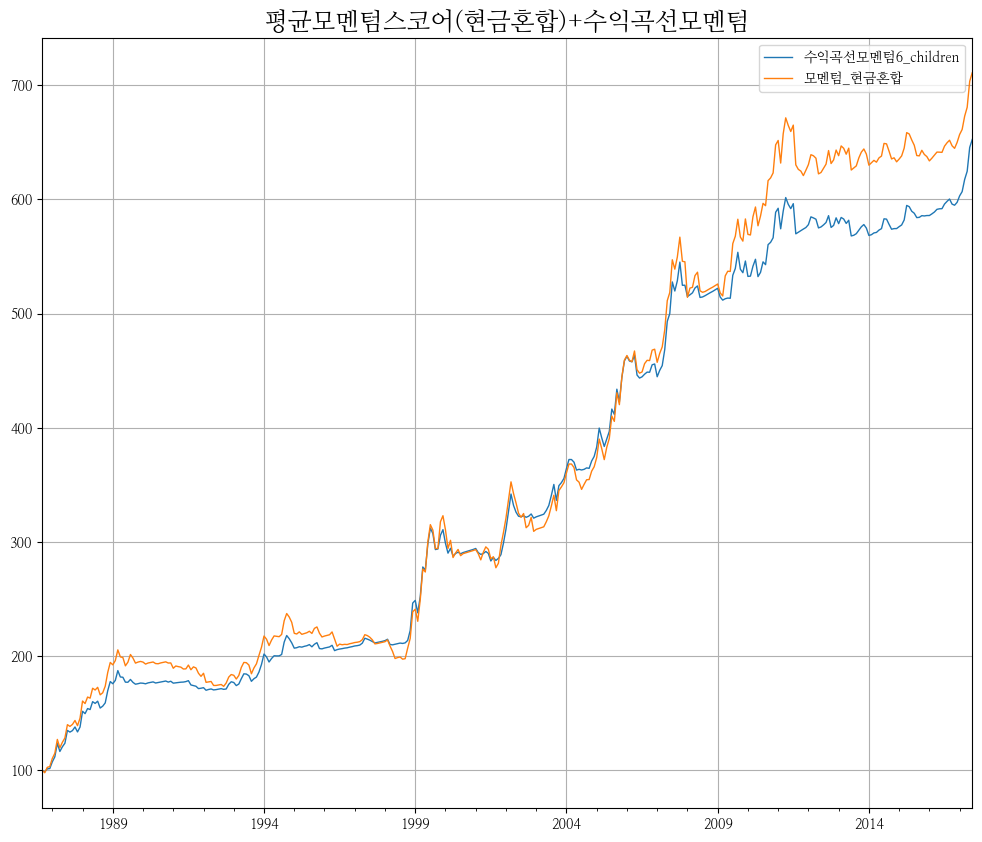

In [17]:
ax1 = r_수익곡선모멘텀6_children.plot(freq='M',figsize=(12,10));
r_모멘텀_현금혼합.plot(ax=ax1, freq='M',figsize=(12,10));
plt.title("평균모멘텀스코어(현금혼합)+수익곡선모멘텀", fontsize=18);

In [18]:
r_all = bt.run(bt_수익곡선모멘텀6_children, bt_모멘텀_현금혼합)

In [19]:
r_all.set_date_range(start수익곡선모멘텀,e)
r_all.display()

Stat                 수익곡선모멘텀6_children    모멘텀_현금혼합
-------------------  --------------------------  -----------------
Start                1986-09-01                  1986-09-01
End                  2017-06-30                  2017-06-30
Risk-free rate       0.00%                       0.00%

Total Return         544.56%                     600.32%
Daily Sharpe         0.88                        0.78
Daily Sortino        1.39                        1.26
CAGR                 6.23%                       6.52%
Max Drawdown         -12.64%                     -18.84%
Calmar Ratio         0.49                        0.35

MTD                  1.06%                       1.06%
3m                   5.55%                       5.55%
6m                   9.20%                       9.39%
YTD                  9.20%                       9.39%
1Y                   10.23%                      10.87%
3Y (ann.)            4.34%                       3.68%
5Y (ann.)            2.53%                 

                   CAGR
수익곡선모멘텀6_children 6.231
모멘텀_현금혼합          6.517
                      MDD
수익곡선모멘텀6_children -12.642
모멘텀_현금혼합          -18.838


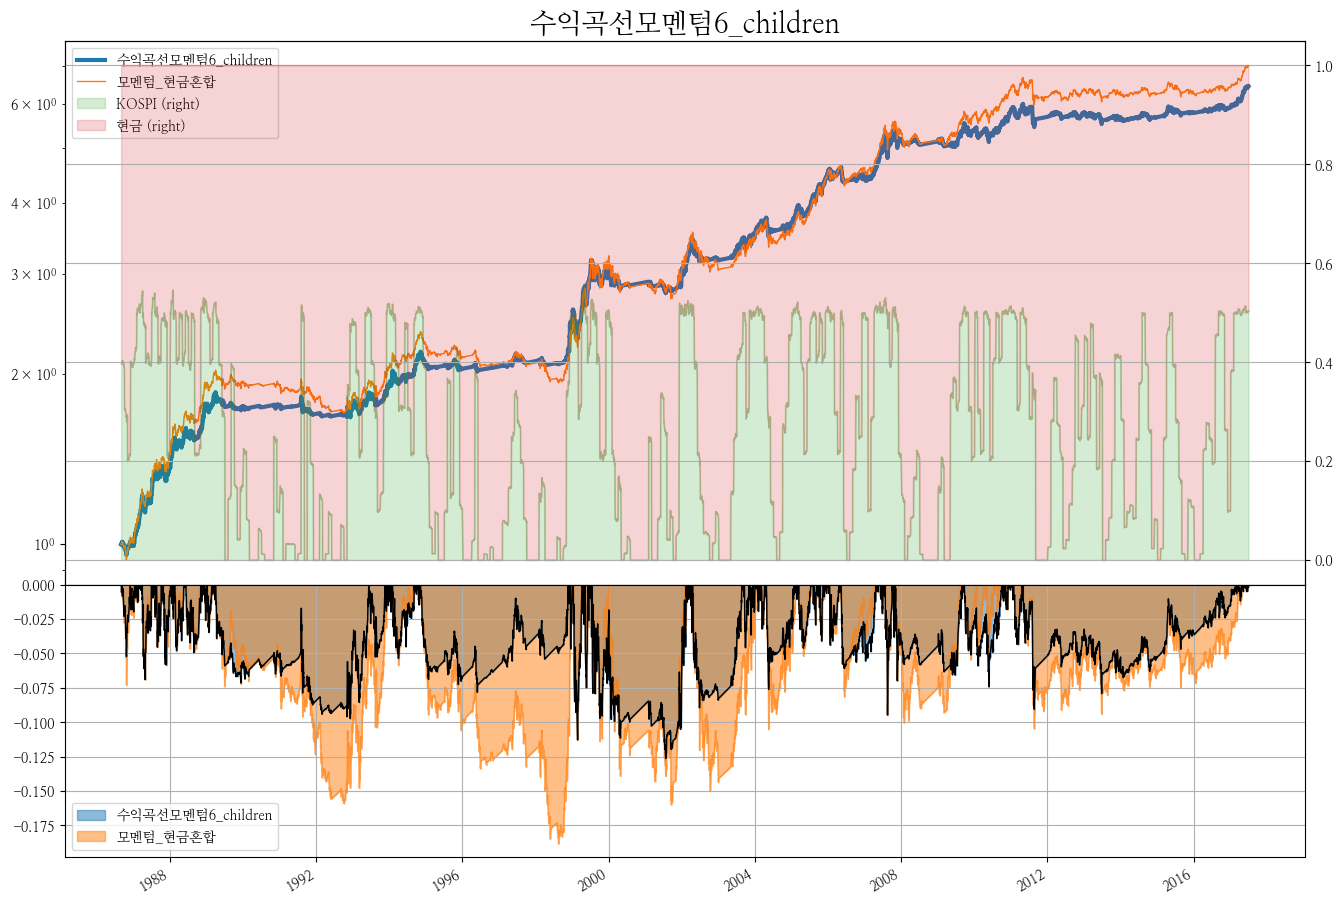

In [20]:
plot_assets(r_all, start수익곡선모멘텀,e, "수익곡선모멘텀6_children")